# Market Basket Analysis of Online Retail Data

This market basket analysis project offers key insights into the purchasing behaviors of wholesalers from a UK-based online retail dataset. Leveraging association rule mining techniques, significant product relationships were identified, driving strategic decisions for inventory management, product bundling, and marketing campaigns.

**Dataset:** The Online Retail dataset contains transactions from December 2010 to December 2011.

**Objective:** Extract actionable insights about customer purchasing behaviors to support business strategies.

## 1. Data Exploration

Exploratory analysis is performed to understand the structure, patterns, and potential issues in the dataset. 

In [8]:
import pandas as pd

# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

# Explore the dataset
print(df.describe())
print('----------------------------------')
print(df.isnull().sum())
print('----------------------------------')
print(df.shape)


            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  
----------------------------------
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice        

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 2. Data Preprocessing

Data cleaning and preparation steps, including handling missing values, filtering transactions, and formatting data for association rule mining.

In [11]:
# Drop rows where Description or CustomerID is null
df_cleaned = df.dropna(subset=['Description', 'CustomerID'])

# Identify rows where Quantity is negative but UnitPrice is greater than 0
invalid_rows = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['UnitPrice'] > 0)]

# Update UnitPrice to be positive for these rows
df_cleaned.loc[invalid_rows.index, 'UnitPrice'] = df_cleaned.loc[invalid_rows.index, 'UnitPrice'].abs()

# Drop rows where UnitPrice is 0 or negative
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]


# Convert negative quantities to positive
df_cleaned.loc[df_cleaned['Quantity'] < 0, 'Quantity'] = df_cleaned.loc[df_cleaned['Quantity'] < 0, 'Quantity'].abs()


df_cleaned.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406789.000000,406789,406789.000000,406789.000000
mean,13.379467,2011-07-10 16:28:44.845459968,3.460811,15287.795830
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13954.000000
50%,5.000000,2011-07-31 11:46:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,247.858601,NaN,69.318561,1713.573064


In [12]:
# Strip extra spaces and convert Description to lowercase for consistency
df_cleaned['Description'] = df_cleaned['Description'].str.strip().str.lower()

# Map StockCode to its consistent Description
stockcode_to_description = df_cleaned.groupby('StockCode')['Description'].first().to_dict()
df_cleaned['Description'] = df_cleaned['StockCode'].map(stockcode_to_description)


In [13]:
# Create a transaction-level dataset
items = list(df_cleaned.Description.unique())
grouped = df_cleaned.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo', 'Description']]

# Transform into transaction dictionary format
transaction_dict = {item: 0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item: 0 for item in items}
    transaction_dict.update({item: 1 for item in items if item in items_list})
    temp.update({invoice_num: transaction_dict})

# Convert transactions to DataFrame
new = [v for k, v in temp.items()]
transaction_df = pd.DataFrame(new)
transaction_df.shape


(22186, 3658)

## 3. Association Rule Mining

Apply the Apriori algorithm to generate frequent itemsets and derive association rules. Rules are evaluated using metrics such as support, confidence, and lift.

In [17]:
# Calculate the support for each item
item_support = transaction_df.sum(axis=0) / len(transaction_df)

# Filter items with support >= 0.02
frequent_items = item_support[item_support >= 0.02].index

# Keep only frequent items
transaction_df = transaction_df[frequent_items]

# Remove rows with no frequent items
transaction_df = transaction_df.loc[transaction_df.sum(axis=1) > 0]


In [18]:
from mlxtend.frequent_patterns import apriori, association_rules

# Compute frequent itemsets
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3, num_itemsets=len(frequent_itemsets))

# Sort rules by lift
rules = rules.sort_values(by="lift", ascending=False)

# Format antecedents and consequents
rules['antecedent'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequent'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Select and reorder columns
formatted_rules = rules[['consequent', 'antecedent', 'support', 'confidence', 'lift']]

# Group by 'consequent' and 'antecedent' to avoid duplicates
formatted_rules = formatted_rules.groupby(['consequent', 'antecedent']).first().reset_index()

# Sort by key metrics
formatted_rules = formatted_rules.sort_values(by=['support', 'confidence', 'lift'], ascending=False)

# Save as a DataFrame
formatted_rules_df = formatted_rules
formatted_rules_df


C:\Users\Abhishek\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,consequent,antecedent,support,confidence,lift
669,roses regency teacup and saucer,green regency teacup and saucer,0.031711,0.759891,15.965889
61,green regency teacup and saucer,roses regency teacup and saucer,0.031711,0.666268,15.965889
170,jumbo bag red retrospot,jumbo bag pink polkadot,0.031540,0.626697,6.699896
140,jumbo bag pink polkadot,jumbo bag red retrospot,0.031540,0.337188,6.699896
23,alarm clock bakelike red,alarm clock bakelike green,0.030515,0.662546,12.830900
...,...,...,...,...,...
632,plasters in tin woodland animals,plasters in tin skulls,0.010020,0.394619,11.708581
369,lunch bag dolly girl design,"lunch bag black skull., lunch bag suki design",0.010020,0.376874,10.941795
608,paper chain kit vintage christmas,60 cake cases vintage christmas,0.010020,0.373673,9.257499
648,"red retrospot charlotte bag, charlotte bag suk...",strawberry charlotte bag,0.010020,0.349206,20.378105


## 4. Results Visualization

Visualize the association rules using scatter plots to identify high-confidence and high-lift rules. Filtered rules with significant metrics are displayed.

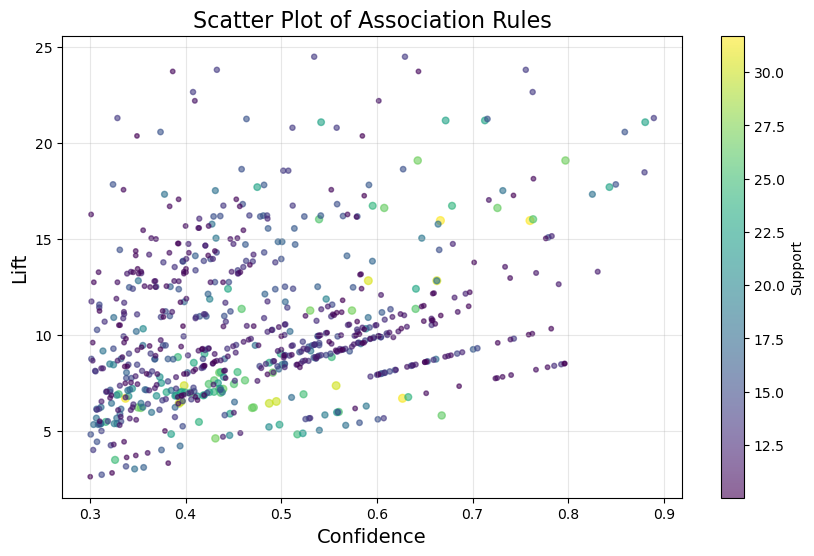

In [19]:
import matplotlib.pyplot as plt

# Prepare data for the scatter plot
x = formatted_rules_df['confidence']
y = formatted_rules_df['lift']
sizes = formatted_rules_df['support'] * 1000  # Scale support for better visualization

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, s=sizes, alpha=0.6, c=sizes, cmap='viridis')

# Add labels and title
plt.title('Scatter Plot of Association Rules', fontsize=16)
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('Lift', fontsize=14)
plt.colorbar(label='Support')
plt.grid(alpha=0.3)

# # Annotate the most relevant points (e.g., highest lift)
# top_lift = formatted_rules_df.sort_values(by='lift', ascending=False).head(5)
# for _, row in top_lift.iterrows():
#     plt.annotate(row['consequent'], (row['confidence'], row['lift']), fontsize=10, alpha=0.8)

# Show the plot
plt.show()


In [21]:
# Function to wrap text in the 'antecedent' column
def wrap_text(text, width=50):
    import textwrap
    return '<br>'.join(textwrap.wrap(text, width=width))

# Apply wrapping to the 'antecedent' column
filtered_rules['antecedent'] = filtered_rules['antecedent'].apply(wrap_text)

# Display the DataFrame with HTML formatting
filtered_rules.style.format({'antecedent': lambda x: f'<div style="white-space: nowrap;">{x}</div>'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_1532\1186811867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['antecedent'] = filtered_rules['antecedent'].apply(wrap_text)


,consequent,antecedent,support,confidence,lift
669,roses regency teacup and saucer,green regency teacup and saucer,0.031711,0.759891,15.965889
57,green regency teacup and saucer,pink regency teacup and saucer,0.026815,0.796954,19.097548
53,gardeners kneeling pad keep calm,gardeners kneeling pad cup of tea,0.026530,0.725857,16.622781
671,roses regency teacup and saucer,pink regency teacup and saucer,0.025676,0.763113,16.033596
62,green regency teacup and saucer,"roses regency teacup and saucer, pink regencyteacup and saucer",0.022602,0.880266,21.093961
670,roses regency teacup and saucer,"green regency teacup and saucer, pink regencyteacup and saucer",0.022602,0.842887,17.709711
614,pink regency teacup and saucer,"green regency teacup and saucer, roses regencyteacup and saucer",0.022602,0.712747,21.183416
672,roses regency teacup and saucer,"regency cakestand 3 tier, green regency teacup andsaucer",0.017990,0.825065,17.335253
59,green regency teacup and saucer,"regency cakestand 3 tier, roses regency teacup andsaucer",0.017990,0.731481,17.528611
58,green regency teacup and saucer,"regency cakestand 3 tier, pink regency teacup andsaucer",0.015599,0.858934,20.582781


## 5. Key Findings:


### Cross-Category Opportunities:

The market basket analysis uncovered compelling cross-category associations that highlight opportunities for targeted business strategies.

**High Tea Essentials Bundle:**
Products like the Regency Cakestand 3 Tier demonstrate strong associations with various teacups (Green, Pink, and Roses). This reveals a clear opportunity to create bundled offerings like "High Tea Essentials", appealing to aesthetic-minded customers who value cohesive dining experiences. These bundles could cater to wholesalers targeting retailers in the hospitality and gifting industries, such as boutique cafes, tea rooms, and high-end gift shops, enabling them to attract customers with curated, ready-to-use tea sets.

**Complementary Home Decor Collections:**
Items like Wooden Picture Frames and White Hanging Heart T-Light Holders frequently appear in the same transaction, reflecting their appeal as cohesive home decor pieces. This insight suggests potential for promoting pre-packaged gift sets tailored for home decor retailers or targeted promotions for aesthetic-focused consumers. Retailers in the home decor industry can capitalize on these associations to enhance their product offerings and drive sales in the gifting and interior design markets.

These findings not only emphasize the importance of bundling strategies but also provide actionable insights for targeted promotions, curated collections, and product innovation across the gifting, hospitality, and home decor sectors.